In [15]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from pyts.transformation import ROCKET
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score

In [16]:
def load_h5_to_dataframe(file_path):
    with h5py.File(file_path, "r") as f:
        print("Keys: %s" % list(f.keys()))
        
        dataframes = []
        for key in list(f.keys()):
            print(f"Loading {key}: {type(f[key])}")
            dataset = np.array(f[key])
            
            if dataset.ndim > 1:
                num_features = dataset.shape[1]
                columns = [f"{key}_{i}" for i in range(num_features)]
                df = pd.DataFrame(dataset, columns=columns)
            else:
                df = pd.DataFrame(dataset, columns=[key])
            
            dataframes.append(df)
        
        combined_df = pd.concat(dataframes, axis=1)
        return combined_df

In [17]:
# Leer los datos
train_path = 'train.h5'
test_path = 'test.h5'

train_data = load_h5_to_dataframe(train_path)
test_data = load_h5_to_dataframe(test_path)

# Dividir los datos en características y etiquetas
X = train_data.drop(columns=['y'])
Y = train_data['y']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=104, test_size=0.30, shuffle=True)

Keys: ['body_acc_x', 'body_acc_y', 'body_acc_z', 'body_gyro_x', 'body_gyro_y', 'body_gyro_z', 'total_acc_x', 'total_acc_y', 'total_acc_z', 'y']
Loading body_acc_x: <class 'h5py._hl.dataset.Dataset'>
Loading body_acc_y: <class 'h5py._hl.dataset.Dataset'>
Loading body_acc_z: <class 'h5py._hl.dataset.Dataset'>
Loading body_gyro_x: <class 'h5py._hl.dataset.Dataset'>
Loading body_gyro_y: <class 'h5py._hl.dataset.Dataset'>
Loading body_gyro_z: <class 'h5py._hl.dataset.Dataset'>
Loading total_acc_x: <class 'h5py._hl.dataset.Dataset'>
Loading total_acc_y: <class 'h5py._hl.dataset.Dataset'>
Loading total_acc_z: <class 'h5py._hl.dataset.Dataset'>
Loading y: <class 'h5py._hl.dataset.Dataset'>
Keys: ['body_acc_x', 'body_acc_y', 'body_acc_z', 'body_gyro_x', 'body_gyro_y', 'body_gyro_z', 'total_acc_x', 'total_acc_y', 'total_acc_z']
Loading body_acc_x: <class 'h5py._hl.dataset.Dataset'>
Loading body_acc_y: <class 'h5py._hl.dataset.Dataset'>
Loading body_acc_z: <class 'h5py._hl.dataset.Dataset'>
Loadi

In [18]:
# Aplicar ROCKET
rocket = ROCKET()
X_train_rocket = rocket.fit_transform(X_train)
X_test_rocket = rocket.transform(X_test)

In [19]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_rocket)
X_test_scaled = scaler.transform(X_test_rocket)

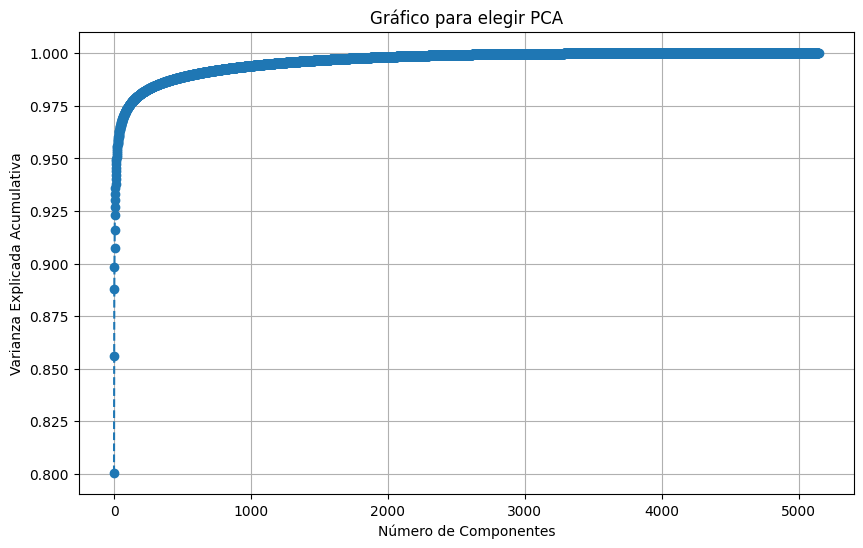

In [20]:
# Aplicar PCA para reducir la dimensionalidad
pca = PCA().fit(X_train_scaled)
explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
plt.plot(explained_variance, marker='o', linestyle='--')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Explicada Acumulativa')
plt.title('Gráfico para elegir PCA')
plt.grid(True)
plt.show()

In [21]:
# Seleccionar el número de componentes que explican el 95% de la varianza
n_components = np.argmax(explained_variance >= 0.95) + 1

# Aplicar PCA con el número seleccionado de componentes
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f'Mejor numero de componentes: {n_components}')

Mejor numero de componentes: 20


In [22]:
from queue import PriorityQueue

# Encuentra los k puntos de X más cercanos a p
def knn(p, X, k):
    k_dist = PriorityQueue(k)
    for i in range(len(X)):
        dist = np.linalg.norm(X[i] - p)
        if not k_dist.full():
            k_dist.put((-dist, i))
        else:
            least_min = k_dist.get()
            if dist < abs(least_min[0]):
                k_dist.put((-dist, i))
            else:
                k_dist.put(least_min)
    return k_dist

# Predice etiquetas para X usando el dataset (X_train, Y_train)
def train_knn(X, k, X_train, Y_train):
    Y = list(Y_train)
    y_pred = []
    for p in X:
        k_elem = knn(p, X_train, k)
        y_temp = []
        while not k_elem.empty():
            idx = k_elem.get()[1]
            y_temp.append(Y[idx])
        y_pred.append(max(set(y_temp), key = y_temp.count))
    return y_pred

In [26]:
# encontrar mejor k

accuracy = []
for k in range(10):
    y_pred = train_knn(X_test_pca, k+1, X_train_pca, y_train)
    accuracy.append(accuracy_score(y_test, y_pred))

best_k = np.argmax(accuracy) + 1
print('Mejor k: ', best_k)
print('Resultado del Accuracy:', accuracy[best_k-1])
print(accuracy)

Mejor k:  1
Resultado del Accuracy: 0.958295557570263
[0.958295557570263, 0.9406165004533091, 0.9474161378059837, 0.9465095194922938, 0.9465095194922938, 0.942429737080689, 0.9437896645512239, 0.942883046237534, 0.9410698096101541, 0.9388032638259293]


In [6]:
y_pred = train_knn(X_test_pca, best_k, X_train_pca, y_train)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print(f"Modelo Usado: KNN:")
print("Resultado del Accuracy:", accuracy)
print("Resultado del F1-Score:", f1)
print("Reporte del Modelo:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", cm)
print("\n")

NameError: name 'train_knn' is not defined